_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

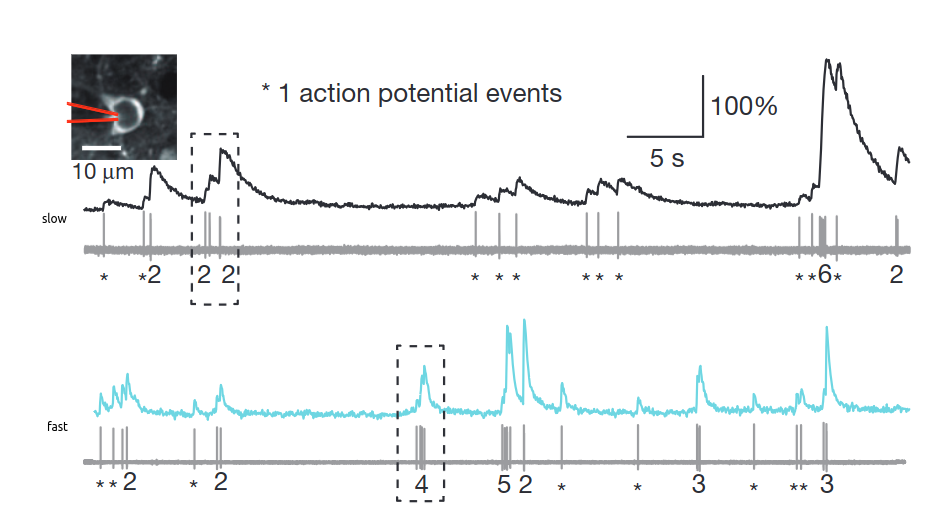

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import decimate, lfilter
from __future__ import annotations
import logging


%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-11 17:08:07CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

sklearn: 1.3.2

numpy     : 1.26.2
seaborn   : 0.13.0
scipy     : 1.11.4
logging   : 0.5.1.2
matplotlib: 3.8.0
pandas    : 2.2.3

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_15764/928315864.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_15764/928315864.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_15764/928315864.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_15764/928315864.py:8: FutureWarning: DataFrame.fillna wi

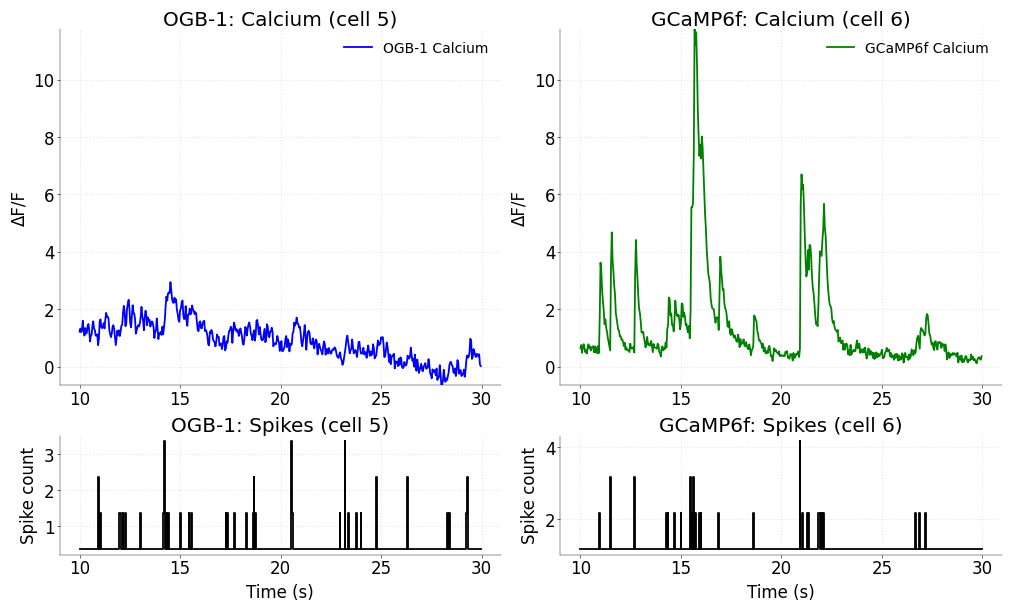

In [4]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------


# CLEAN: interpolate and fill any NaNs
def clean_df(df):
    return df.interpolate(axis=0).fillna(method="bfill").fillna(method="ffill")


ogb_cal = clean_df(ogb_calcium)
ogb_spk = clean_df(ogb_spikes)
gcamp_cal = clean_df(gcamp_calcium)
gcamp_spk = clean_df(gcamp_spikes)

# DOWNSAMPLING FUNCTIONS
DOWNSAMPLE_FACTOR = 4  # 100 Hz → 25 Hz


def downsample_calcium(df):
    """Zero-phase FIR decimation of each continuous trace."""
    return df.apply(
        lambda col: decimate(
            col.values, DOWNSAMPLE_FACTOR, ftype="fir", zero_phase=True
        ),
        axis=0,
        result_type="expand",
    ).set_axis(df.columns, axis=1)


def downsample_spikes(df):
    """Bin & sum integer spike counts into non-overlapping windows."""
    arr = df.values
    n_bins = arr.shape[0] // DOWNSAMPLE_FACTOR
    arr = arr[: n_bins * DOWNSAMPLE_FACTOR]
    binned = arr.reshape(n_bins, DOWNSAMPLE_FACTOR, arr.shape[1]).sum(axis=1)
    return pd.DataFrame(binned, columns=df.columns)


# APPLY DOWNSAMPLING
ogb_cal_ds = downsample_calcium(ogb_cal)
ogb_spk_ds = downsample_spikes(ogb_spk)
gcamp_cal_ds = downsample_calcium(gcamp_cal)
gcamp_spk_ds = downsample_spikes(gcamp_spk)

# DEFINE SEGMENT & TIME VECTOR
start_t, end_t = 10, 30  # seconds
sr_new = 25  # Hz after downsampling
start_idx = start_t * sr_new
end_idx = end_t * sr_new
time = np.linspace(start_t, end_t, end_idx - start_idx, endpoint=False)

cell_ogb, cell_gcamp = 5, 6

# EXTRACT SEGMENTS
ogb_cal_seg = ogb_cal_ds.iloc[start_idx:end_idx, cell_ogb]
ogb_spk_seg = ogb_spk_ds.iloc[start_idx:end_idx, cell_ogb]
gcamp_cal_seg = gcamp_cal_ds.iloc[start_idx:end_idx, cell_gcamp]
gcamp_spk_seg = gcamp_spk_ds.iloc[start_idx:end_idx, cell_gcamp]

# DYNAMIC OFFSETS FOR SPIKES
offset_ogb = 0.1 * (ogb_cal_seg.max() - ogb_cal_seg.min())
offset_gcamp = 0.1 * (gcamp_cal_seg.max() - gcamp_cal_seg.min())

# --------------------
# Plot OGB data (1 pt)
# --------------------


# ----------------------
# Plot GCamp data (1 pt)
# ----------------------


plt.rcParams.update(
    {
        "font.size": 12,
        "lines.linewidth": 1.3,
    }
)

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 6),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

# Top-left: OGB-1 calcium (blue)
axs[0, 0].plot(time, ogb_cal_seg, color="blue", label="OGB-1 Calcium")
axs[0, 0].set_title("OGB-1: Calcium (cell 5)")
axs[0, 0].set_ylabel("ΔF/F")
axs[0, 0].legend(loc="upper right")

# Top-right: GCaMP6f calcium (green)
axs[0, 1].plot(time, gcamp_cal_seg, color="green", label="GCaMP6f Calcium")
axs[0, 1].set_title("GCaMP6f: Calcium (cell 6)")
axs[0, 1].set_ylabel("ΔF/F")
axs[0, 1].legend(loc="upper right")

# Match y-limits on both calcium panels
ymin = min(ogb_cal_seg.min(), gcamp_cal_seg.min())
ymax = max(ogb_cal_seg.max(), gcamp_cal_seg.max())
for ax in (axs[0, 0], axs[0, 1]):
    ax.set_ylim(ymin, ymax)

# Bottom-left: OGB-1 spikes (black)
axs[1, 0].step(
    time, ogb_spk_seg + offset_ogb, where="mid", color="black", label="_nolegend_"
)
axs[1, 0].set_title("OGB-1: Spikes (cell 5)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Spike count")

# Bottom-right: GCaMP6f spikes (black)
axs[1, 1].step(
    time, gcamp_spk_seg + offset_gcamp, where="mid", color="black", label="_nolegend_"
)
axs[1, 1].set_title("GCaMP6f: Spikes (cell 6)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Spike count")

# Add subtle gridlines
for ax in axs.flatten():
    ax.grid(alpha=0.3, linestyle=":")

# Save & show
fig.savefig("task1_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

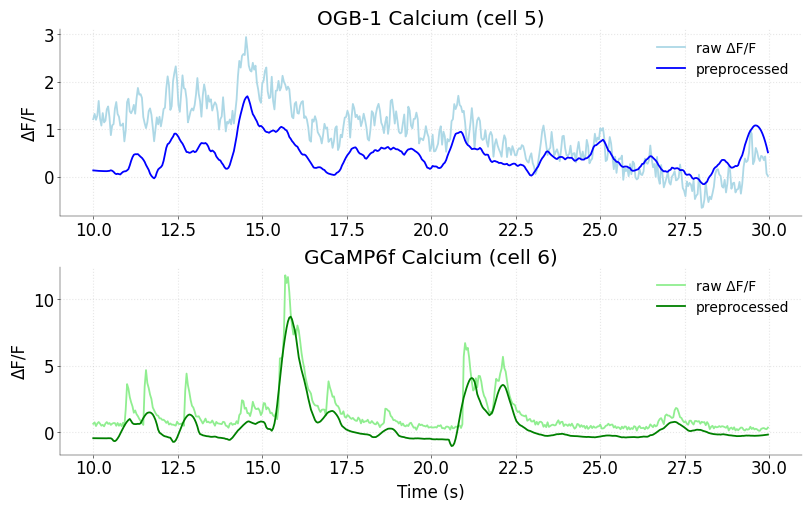

In [5]:
from scipy.signal import butter, filtfilt, savgol_filter


# PARAMETERS
fs = 25  # Hz (after downsampling)
hp_cutoff = 0.01  # Hz, to remove very slow drifts
savgol_window = 21  # samples (~0.6 s window)
savgol_poly = 2  # quadratic fit for Savitzky–Golay

# DESIGN A HIGH-PASS BUTTERWORTH FILTER
b_hp, a_hp = butter(N=2, Wn=hp_cutoff / (fs / 2), btype="highpass")


def preprocess_calcium(trace: np.ndarray) -> np.ndarray:
    """
    (1) Zero-phase high-pass filter to strip slow drifts.
    (2) Savitzky–Golay smoothing to suppress high-frequency noise
        while preserving transient shape.
    """
    # remove DC offset
    centered = trace - np.nanmean(trace)
    # high-pass
    hp = filtfilt(b_hp, a_hp, centered)
    # Savitzky–Golay smoothing
    sg = savgol_filter(hp, savgol_window, polyorder=savgol_poly, mode="interp")
    return sg


# APPLY TO SEGMENTS
ogb_cal_filt = preprocess_calcium(ogb_cal_seg.values)
gcamp_cal_filt = preprocess_calcium(gcamp_cal_seg.values)

# PLOT RAW vs PREPROCESSED
fig, axs = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)
t = time  # your 10–30 s time vector

# OGB-1 panel
axs[0].plot(t, ogb_cal_seg, color="lightblue", label="raw ΔF/F")
axs[0].plot(t, ogb_cal_filt, color="blue", label="preprocessed")
axs[0].set_title("OGB-1 Calcium (cell 5)")
axs[0].set_ylabel("ΔF/F")
axs[0].legend()
axs[0].grid(alpha=0.3, linestyle=":")

# GCaMP6f panel
axs[1].plot(t, gcamp_cal_seg, color="lightgreen", label="raw ΔF/F")
axs[1].plot(t, gcamp_cal_filt, color="green", label="preprocessed")
axs[1].set_title("GCaMP6f Calcium (cell 6)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("ΔF/F")
axs[1].legend()
axs[1].grid(alpha=0.3, linestyle=":")

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_15764/1559813834.py:151: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


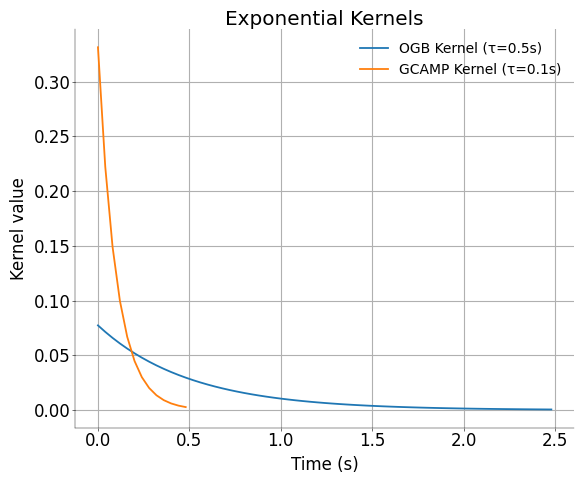

In [6]:
def init_config():
    """Initialize the configuration for the analysis."""
    config = {
        "sampling_rate": 100,
        "new_sampling_rate": 25,
        "decimate_factor": 4,
        "start_time": 10,
        "end_time": 30,
        "tau_ogb": 0.5,
        "tau_gcamp": 0.1,
        "cell_ogb": 5,
        "cell_gcamp": 6,
        "deconvolution_plot_start_time": 10,
        "deconvolution_plot_end_time": 30,
    }
    # Downsample factor: 100 Hz → 25 Hz → factor = 4
    config["downsample_factor"] = config["sampling_rate"] // config["new_sampling_rate"]
    config["dt"] = 1 / config["new_sampling_rate"]  # 0.04 s

    # plotting timestamps:
    config["deconvolution_plot_start_index"] = int(
        config["deconvolution_plot_start_time"] * config["new_sampling_rate"]
    )
    config["deconvolution_plot_end_index"] = int(
        config["deconvolution_plot_end_time"] * config["new_sampling_rate"]
    )
    start = config["deconvolution_plot_start_index"]
    end = config["deconvolution_plot_end_index"]

    config["deconvolution_plot_time_segment"] = (
        np.arange(start, end) / config["new_sampling_rate"]
    )  # Absolute time
    return config


config = init_config()


def get_exponential_decay_kernel(tau: float, dt: float) -> np.ndarray:
    """
    Generates an exponential decay kernel.

    Parameters
    ----------
    tau : float
        Decay constant of the kernel.
    dt : float
        Sampling interval.

    Returns
    -------
    np.ndarray
        The generated exponential decay kernel, normalized to have unit area.
    """
    # Define kernel duration to cover approximately 5 times the decay constant.
    # This ensures the kernel captures the significant part of the decay.
    kernel_len = int(np.ceil(5 * tau / dt))

    # Create a time vector for the kernel.
    # It starts from 0 and goes up to (kernel_len - 1) * dt.
    t = np.arange(kernel_len) * dt

    # Create the exponential decay kernel using the formula: exp(-t / tau).
    kernel = np.exp(-t / tau)

    # Normalize the kernel so that its sum is 1 (unit area).
    # This is important for deconvolution to preserve signal amplitude.
    if (
        kernel.sum() > 0
    ):  # Avoid division by zero if kernel is all zeros (e.g., tau is very small)
        kernel /= kernel.sum()

    return kernel


def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    # Create the exponential decay kernel using the provided tau and dt.
    # This kernel models the calcium signal decay.
    # The kernel is normalized to ensure it has unit area.
    # This is important for deconvolution to preserve signal amplitude.
    kernel = get_exponential_decay_kernel(tau, dt)
    logging.debug(f"Kernel shape: {kernel.shape}")

    # Use scipy to deconvolve
    sp_hat, _ = signal.deconvolve(ca, kernel)

    # Pad the output to match original size (deconvolve returns shorter output)
    sp_hat = np.pad(sp_hat, (0, ca.shape[0] - sp_hat.shape[0]), mode="constant")

    # Clip negative values
    sp_hat = np.clip(sp_hat, 0, None)

    return sp_hat


kernels = {
    "OGB": get_exponential_decay_kernel(config["tau_ogb"], config["dt"]),
    "GCaMP": get_exponential_decay_kernel(config["tau_gcamp"], config["dt"]),
}


# Plot the kernels
def plot_kernels(kernels: dict, config: dict):
    """
    Plots the exponential decay kernels for OGB and GCaMP.

    Parameters
    ----------
    kernels : dict
        Dictionary containing the kernel names and their corresponding values.
    config : dict
        Configuration dictionary containing parameters like dt and tau.
    """
    fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")
    for name, kernel in kernels.items():
        t = np.arange(len(kernel)) * config["dt"]
        ax.plot(
            t,
            kernel,
            label=f"{name.upper()} Kernel (τ={config['tau_ogb'] if name == 'OGB' else config['tau_gcamp']}s)",
        )
    ax.set_title("Exponential Kernels")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Kernel value")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


plot_kernels(kernels, config)

In [7]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------


# -------------------------
# Task 2: Simple deconvolution
# -------------------------

# 1) parameters (from your notebook)
sr_new = 25.0  # Hz after downsampling
dt = 1.0 / sr_new  # s per sample
tau_ogb = 0.5  # OGB-1 decay constant (s)
tau_gcamp = 0.1  # GCaMP6f decay constant (s)
t0, t1 = 10.0, 30.0  # seconds window to plot

cell_ogb = 5  # the column index you chose for OGB-1
cell_gcamp = 6  # the column index for GCaMP6f


# grab your full ΔF/F vectors
ca_full_ogb = ogb_cal_ds.iloc[:, cell_ogb].values
ca_full_gcamp = gcamp_cal_ds.iloc[:, cell_gcamp].values

# run deconvolution
s_full_ogb = deconv_ca(ca_full_ogb, tau_ogb, dt)
s_full_gcamp = deconv_ca(ca_full_gcamp, tau_gcamp, dt)

s_full_ogb.shape, s_full_gcamp.shape

((17997,), (5994,))

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

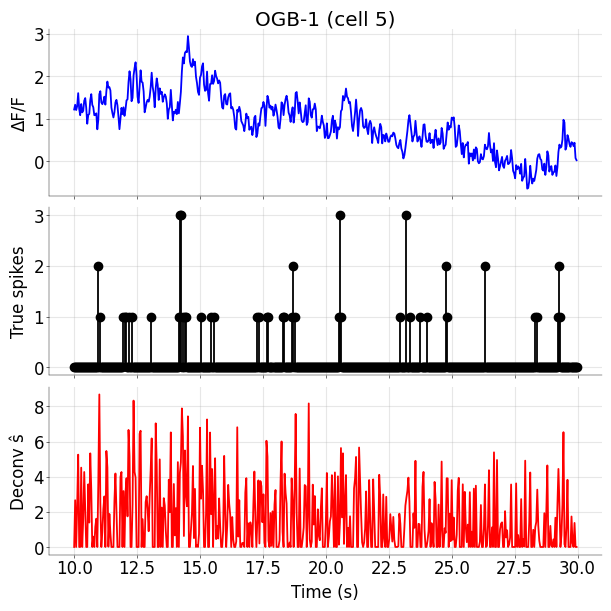

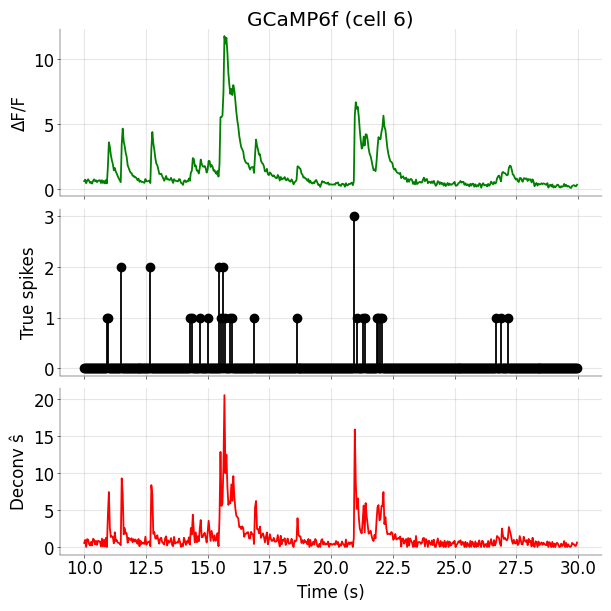

In [8]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------


# OGB Cell

# GCamp Cell
# slice out the 10–30 s window
i0 = int(t0 * sr_new)
i1 = int(t1 * sr_new)
time = np.linspace(t0, t1, i1 - i0, endpoint=False)

seg_cal_ogb = ca_full_ogb[i0:i1]
seg_spk_ogb = ogb_spk_ds.iloc[i0:i1, cell_ogb].values
seg_hat_ogb = s_full_ogb[i0:i1]

seg_cal_gc = ca_full_gcamp[i0:i1]
seg_spk_gc = gcamp_spk_ds.iloc[i0:i1, cell_gcamp].values
seg_hat_gc = s_full_gcamp[i0:i1]

# Plot OGB‐1
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
ax[0].plot(time, seg_cal_ogb, color="blue")
ax[0].set_ylabel("ΔF/F")
ax[0].set_title(f"OGB-1 (cell {cell_ogb})")

ax[1].stem(time, seg_spk_ogb, linefmt="k-", markerfmt="ko", basefmt=" ")
ax[1].set_ylabel("True spikes")

ax[2].plot(time, seg_hat_ogb, color="red")
ax[2].set_ylabel("Deconv ŝ")
ax[2].set_xlabel("Time (s)")

for a in ax:
    a.grid(alpha=0.3)


# 6) Plot GCaMP6f
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
ax[0].plot(time, seg_cal_gc, color="green")
ax[0].set_ylabel("ΔF/F")
ax[0].set_title(f"GCaMP6f (cell {cell_gcamp})")

ax[1].stem(time, seg_spk_gc, linefmt="k-", markerfmt="ko", basefmt=" ")
ax[1].set_ylabel("True spikes")

ax[2].plot(time, seg_hat_gc, color="red")
ax[2].set_ylabel("Deconv ŝ")
ax[2].set_xlabel("Time (s)")

for a in ax:
    a.grid(alpha=0.3)

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [9]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
# !wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
# import oopsi

In [10]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

import oasis.functions


# Define a simple Oasis wrapper
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = oasis.functions.deconvolve(trace, penalty=penalty, optimize_g=False)
    return s


# Parameters and indices
fs = 25  # sampling rate after downsampling (Hz)
t0, t1 = 20.0, 30.0  # window in seconds
i0, i1 = int(t0 * fs), int(t1 * fs)  # sample indices 500 → 750
time = np.linspace(t0, t1, i1 - i0, endpoint=False)  # 250 points

cell_ogb = 5  # example OGB cell index
cell_gcamp = 6  # example GCaMP cell index

# Grab full preprocessed ΔF/F and ground‐truth spikes from Task 1
full_ca_ogb = ogb_cal_ds.iloc[:, cell_ogb].values
full_spk_ogb = ogb_spk_ds.iloc[:, cell_ogb].values

full_ca_gcamp = gcamp_cal_ds.iloc[:, cell_gcamp].values
full_spk_gcamp = gcamp_spk_ds.iloc[:, cell_gcamp].values

# Run OASIS deconvolution on the full traces
c_ogb_full, s_ogb_full, *_ = oasis.functions.deconvolve(
    full_ca_ogb, penalty=1.0, optimize_g=False
)
c_gcamp_full, s_gcamp_full, *_ = oasis.functions.deconvolve(
    full_ca_gcamp, penalty=1.0, optimize_g=False
)

c_ogb_full.shape, c_gcamp_full.shape

/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


((17997,), (5994,))

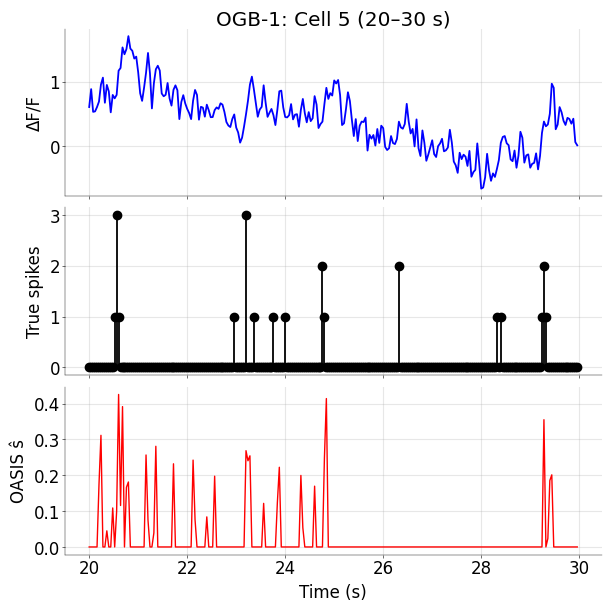

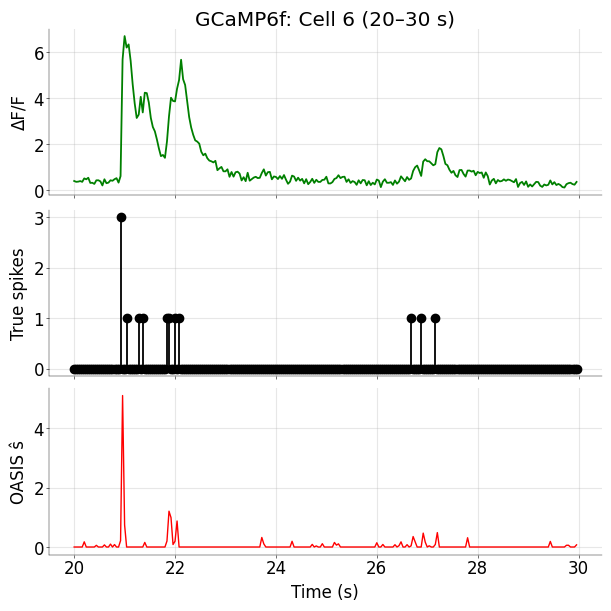

In [11]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

# OGB Cell

# GCamP Cell


# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

# 4) Slice out exactly 20–30 s (250 samples)
seg_ca_ogb = full_ca_ogb[i0:i1]
seg_true_ogb = full_spk_ogb[i0:i1]
seg_hat_ogb = s_ogb_full[i0:i1]

seg_ca_gcamp = full_ca_gcamp[i0:i1]
seg_true_gcamp = full_spk_gcamp[i0:i1]
seg_hat_gcamp = s_gcamp_full[i0:i1]

# Plot OGB-1 results (3×1)
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, seg_ca_ogb, color="blue")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("OGB-1: Cell 5 (20–30 s)")

axs[1].stem(time, seg_true_ogb, linefmt="k-", markerfmt="ko", basefmt=" ")
axs[1].set_ylabel("True spikes")

# ← here’s the only change: use plot() instead of stem()
axs[2].plot(time, seg_hat_ogb, color="red", linewidth=1)
axs[2].set_ylabel("OASIS ŝ")
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()


# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, seg_ca_gcamp, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")

axs[1].stem(time, seg_true_gcamp, linefmt="k-", markerfmt="ko", basefmt=" ")
axs[1].set_ylabel("True spikes")

# ← same change here
axs[2].plot(time, seg_hat_gcamp, color="red", linewidth=1)
axs[2].set_ylabel("OASIS ŝ")
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [12]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------


def run_deconvolution(
    calcium: np.ndarray, tau: float, dt: float, deconvolution_func=deconv_ca
) -> np.ndarray:
    """
    Run deconvolution on calcium data for all cells.

    Parameters
    ----------
    calcium : np.ndarray
        Calcium data of shape (time, n_cells).
    tau : float
        Decay constant for the algorithm.
    dt : float
        Sampling interval.

    Returns
    -------
    np.ndarray
        Inferred spike data of shape (time, n_cells).
    """
    inferred_spikes = np.zeros_like(calcium)
    for cell in range(calcium.shape[1]):  # Iterate over each cell
        inferred_spikes[:, cell] = deconvolution_func(calcium[:, cell], tau=tau, dt=dt)
    return inferred_spikes

/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWar

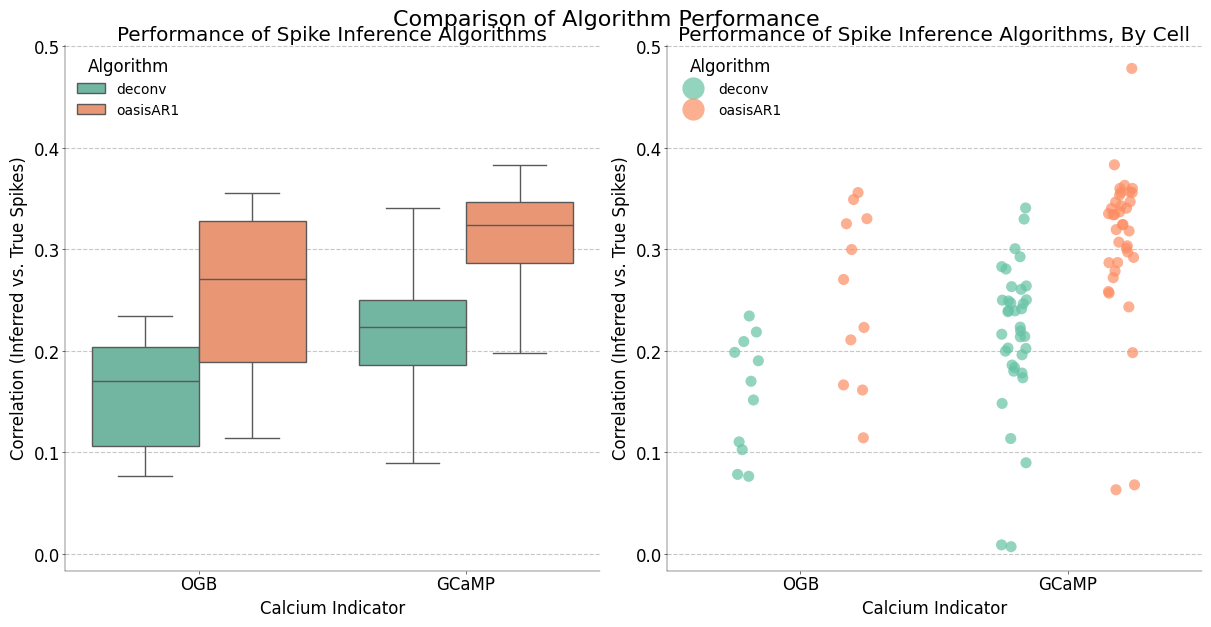

In [13]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------


def run_deconvolution(
    calcium: np.ndarray, tau: float, dt: float, deconvolution_func=deconv_ca
) -> np.ndarray:
    """
    Run deconvolution on calcium data for all cells.

    Parameters
    ----------
    calcium : np.ndarray
        Calcium data of shape (time, n_cells).
    tau : float
        Decay constant for the algorithm.
    dt : float
        Sampling interval.

    Returns
    -------
    np.ndarray
        Inferred spike data of shape (time, n_cells).
    """
    inferred_spikes = np.zeros_like(calcium)
    for cell in range(calcium.shape[1]):  # Iterate over each cell
        inferred_spikes[:, cell] = deconvolution_func(calcium[:, cell], tau=tau, dt=dt)
    return inferred_spikes


# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------


def oasisAR1(trace, tau, dt):
    """AR(1) OASIS spike inference wrapper."""
    return run_oasis(trace)


def evaluate_algorithm(
    algorithm: str,
    calcium: np.ndarray,
    spikes: np.ndarray,
    tau: float,
    dt: float,
    indicator: str,  # Add this to label which dataset (OGB or GCaMP)
) -> pd.DataFrame:
    """
    Evaluate the algorithm on calcium and spike data for all
    cells.

    Parameters
    ----------
    calcium : np.ndarray
        Calcium data of shape (time, n_cells).
    spikes : np.ndarray
        Binned spike data of shape (time, n_cells).
    algorithm : str
        Algorithm to use ("deconv" or "oopsi").
    tau : float
        Decay constant for the algorithm.
    dt : float
        Sampling interval.
    indicator : str
        Indicator label (e.g. "OGB" or "GCaMP").

    Returns
    -------
    pd.DataFrame
        DataFrame with correlation results for each cell.
    """
    # Run the algorithm
    if algorithm == "deconv":
        inferred_spikes = run_deconvolution(calcium, tau=tau, dt=dt)
    elif algorithm == "oasisAR1":
        inferred_spikes = run_deconvolution(
            calcium, dt=dt, tau=tau, deconvolution_func=oasisAR1
        )
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

    # Ensure same shape
    assert (
        inferred_spikes.shape == spikes.shape
    ), f"Shape mismatch: inferred {inferred_spikes.shape}, true {spikes.shape}"

    # Compute correlation for each cell
    results = []
    for cell in range(spikes.shape[1]):
        true_cell = spikes[:, cell]
        inferred_cell = inferred_spikes[:, cell]

        # Optional: handle NaNs if any
        if np.isnan(true_cell).any() or np.isnan(inferred_cell).any():
            corr = np.nan
        else:
            corr = np.corrcoef(true_cell, inferred_cell)[0, 1]

        results.append(
            {
                "algorithm": algorithm,
                "correlation": corr,
                "indicator": indicator,
                "cell": cell,
            }
        )

    return pd.DataFrame(results)


def run_all_algorithms(
    indicators: list[str],
    calcium_data_map: dict,
    spike_data_map: dict,
    algorithm_map: dict,
    tau_map: dict,
    dt: float,
) -> pd.DataFrame:
    """
    Run all algorithms on the provided calcium and spike data.
    Parameters
    ----------
    indicators : list[str]
        List of indicators (e.g. ["OGB", "GCaMP"]).
    calcium_data : dict
        Dictionary mapping indicator names to their respective calcium data.
    spike_data : dict
        Dictionary mapping indicator names to their respective spike data.
    algorithm_map : dict
        Mapping of algorithm names to their respective functions.
    tau_map : dict
        Mapping of indicator names to their respective tau values.
    dt : float
        Sampling interval.
    Returns
    -------
    pd.DataFrame
        DataFrame with correlation results for each cell.
    """
    # List to store individual DataFrame results
    all_results_list = []

    for alg_name, alg_func in algorithm_map.items():
        for indicator in indicators:
            # Get the calcium and spike data for the current indicator
            calcium_data = calcium_data_map[indicator]
            spike_data = spike_data_map[indicator]
            tau = tau_map[indicator]

            logging.debug(
                f"\nEvaluating Algorithms: '{alg_name}' for Indicator: '{indicator}'"
            )
            logging.debug(f"Initial calcium data shape: {calcium_data.shape}")
            logging.debug(f"Initial spike data shape: {spike_data.shape}")
            # Ensure calcium and spike data have the same number of time points (rows)
            # This can be important if decimation and binning led to slight length differences
            min_rows = min(calcium_data.shape[0], spike_data.shape[0])
            aligned_calcium = calcium_data[:min_rows, :]
            aligned_spikes = spike_data[:min_rows, :]
            logging.debug(
                f"Aligned calcium shape for evaluation: {aligned_calcium.shape}"
            )
            logging.debug(
                f"Aligned spikes shape for evaluation: {aligned_spikes.shape}"
            )

            # Call the evaluation function
            df_result = evaluate_algorithm(
                algorithm=alg_name,
                calcium=aligned_calcium,
                spikes=aligned_spikes,
                tau=tau,
                dt=dt,
                indicator=indicator,
            )
            all_results_list.append(df_result)
    # Concatenate all results into the final DataFrame
    if all_results_list:
        eval_results_df = pd.concat(all_results_list, ignore_index=True)
    else:
        eval_results_df = pd.DataFrame()  # Create an empty DataFrame if no results
    return eval_results_df


# %%

full_ca_ogb = ogb_cal_ds.values
full_spk_ogb = ogb_spk_ds.values

full_ca_gcamp = gcamp_cal_ds.values
full_spk_gcamp = gcamp_spk_ds.values


eval_results_df = run_all_algorithms(
    indicators=["OGB", "GCaMP"],
    calcium_data_map={"OGB": full_ca_ogb, "GCaMP": full_ca_gcamp},
    spike_data_map={"OGB": full_spk_ogb, "GCaMP": full_spk_gcamp},
    algorithm_map={
        "deconv": run_deconvolution,
        "oasisAR1": run_oasis,
    },
    tau_map={"OGB": config["tau_ogb"], "GCaMP": config["tau_gcamp"]},
    dt=config["dt"],
)


def box_plot_eval_results(ax, eval_results_df):
    """
    Create a boxplot for the evaluation results.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object to plot on.
    eval_results_df : pd.DataFrame
        DataFrame containing evaluation results with columns:
        'indicator', 'correlation', and 'algorithm'.
    """
    # Set the figure size and layout
    # plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.boxplot(
        x="indicator",  # Categorical variable for the x-axis (groups)
        y="correlation",  # Numerical variable for the y-axis (values to plot)
        hue="algorithm",  # Second categorical variable to group by color
        data=eval_results_df,
        palette="Set2",  # Color palette for different algorithms
        fliersize=0,  # Hide outlier markers from boxplot
        ax=ax,
    )
    ax.set_xlabel("Calcium Indicator")
    ax.set_ylabel("Correlation (Inferred vs. True Spikes)")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend(title="Algorithm")  # Add a legend for the hue
    ax.title.set_text("Performance of Spike Inference Algorithms")


# %%
def strip_plot_eval_results(ax, eval_results_df):
    """
    Create a stripplot for the evaluation results.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object to plot on.
    eval_results_df : pd.DataFrame
        DataFrame containing evaluation results with columns:
        'indicator', 'correlation', and 'algorithm'.
    """
    # Set the figure size and layout
    sns.stripplot(
        x="indicator",  # Categorical variable for the x-axis (groups)
        y="correlation",  # Numerical variable for the y-axis (values to plot)
        hue="algorithm",  # Second categorical variable to group by color
        data=eval_results_df,
        dodge=True,  # Separates the strips for different 'hue' levels along the x-axis
        jitter=True,  # Adds random noise along the categorical axis to prevent points from overlapping
        alpha=0.7,  # Transparency of points (useful if many points overlap)
        palette="Set2",  # Color palette for different algorithms
        size=16,  # Size of the points
        ax=ax,
    )
    ax.set_xlabel("Calcium Indicator")
    ax.set_ylabel("Correlation (Inferred vs. True Spikes)")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend(title="Algorithm")  # Add a legend for the hue
    ax.title.set_text("Performance of Spike Inference Algorithms, By Cell")


# %%
# Create the figure and an array of Axes objects
fig, axes = plt.subplots(
    ncols=2, figsize=(12, 6), layout="constrained"
)  # Renamed 'ax' to 'axes' for clarity

# Set an overall title for the entire figure (optional)
fig.suptitle(
    "Comparison of Algorithm Performance", fontsize=16, y=1.02
)  # y positions suptitle slightly higher

# Call your plotting functions, passing the specific Axes object for each plot
# These functions are expected to set their own titles and legends.
box_plot_eval_results(axes[0], eval_results_df)
strip_plot_eval_results(axes[1], eval_results_df)

# Save the entire figure (which now contains two subplots)
# plt.savefig("../plots/eval_results_comparison_plots.png", dpi=300) # Adjusted filename for clarity
plt.show()

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ahmedeldably/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWar

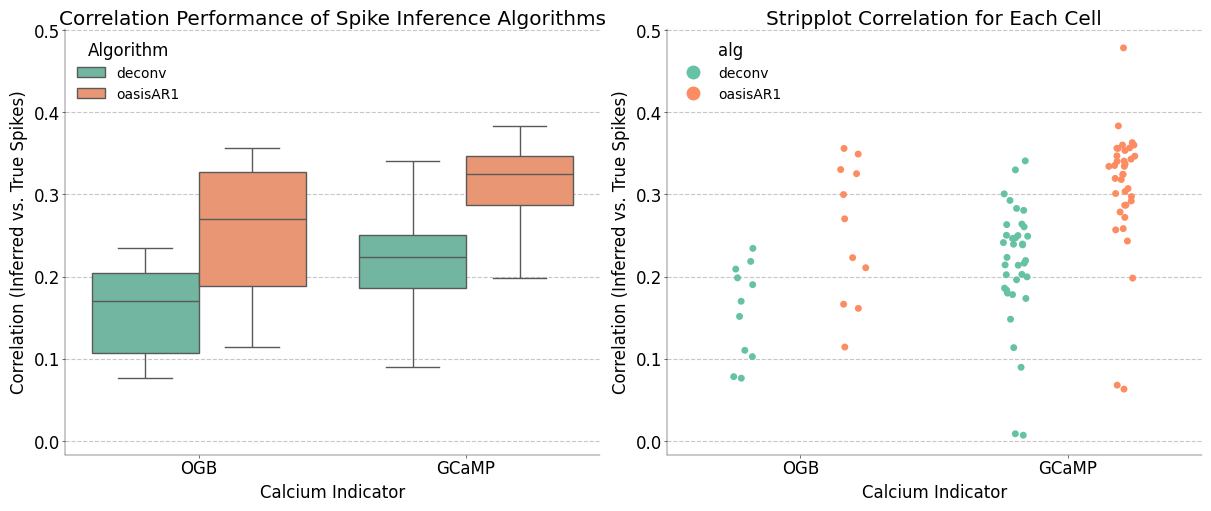

In [24]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

# --- 5) plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
sns.boxplot(
    x="indicator",
    y="correlation",
    hue="algorithm",
    data=eval_results_df,
    palette="Set2",
    fliersize=0,
    ax=axes[0],
)
axes[0].set_title("Boxplot of r (true vs. inferred)")
axes[0].grid(axis="y", alpha=0.3)

sns.stripplot(
    x="indicator",
    y="correlation",
    hue="algorithm",
    data=eval_results_df,
    dodge=True,
    jitter=True,
    palette="Set2",
    ax=axes[1],
    size=10,
)

for ax in axes:
    ax.grid(axis="y", alpha=0.3)
    ax.set_xlabel("Calcium Indicator")
    ax.set_ylabel("Correlation (Inferred vs. True Spikes)")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend(title="Algorithm")  # Add a legend for the hue


axes[0].title.set_text("Correlation Performance of Spike Inference Algorithms")

axes[1].set_title("Stripplot Correlation for Each Cell")


# remove duplicate legends
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[:2], labels[:2], title="alg")

plt.show()